# Modules

In [1]:
%load_ext autoreload
%autoreload 2

In [39]:
import sys

import urllib.request
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, StrMethodFormatter
import matplotlib
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns

from IPython.display import display, HTML
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

sys.path.append('..')
from src import config

plt.rcParams.update(plt.rcParamsDefault)
plt.style.use(['ggplot', 'bmh'])
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

display_settings = {
    'max_columns': 999,
    'expand_frame_repr': True,
    'max_rows': 999,
    'precision': 4,
    'show_dimensions': True
}

for op, value in display_settings.items():
    pd.set_option("display.{}".format(op), value)


%matplotlib inline

# Data

In [3]:
path = config.get_processed_filename('data.parquet')
df = pd.read_parquet(path)

print(f'Consolidated sales series dataset:{df.shape}')
print(df.dtypes)
df.head()

Consolidated sales series dataset:(46027957, 20)
id                      object
item_id               category
dept_id               category
cat_id                category
store_id              category
state_id              category
d                       object
sold_qty                 int64
date            datetime64[ns]
wday                      int8
month                     int8
year                     int16
event_name_1            object
event_type_1          category
event_name_2            object
event_type_2          category
snap_CA                   bool
snap_TX                   bool
snap_WI                   bool
sell_price             float64
Length: 20, dtype: object


,id,item_id,dept_id,cat_id,store_id,state_id,d,sold_qty,date,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_1,12,2011-01-29,1,1,2011,None,NaN,None,NaN,False,False,False,0.46
1,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_2,15,2011-01-30,2,1,2011,None,NaN,None,NaN,False,False,False,0.46
2,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_3,0,2011-01-31,3,1,2011,None,NaN,None,NaN,False,False,False,0.46
3,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_4,0,2011-02-01,4,2,2011,None,NaN,None,NaN,True,True,False,0.46
4,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_5,0,2011-02-02,5,2,2011,None,NaN,None,NaN,True,False,True,0.46


# EDA

# Aggregated sales

### Daily overall sales

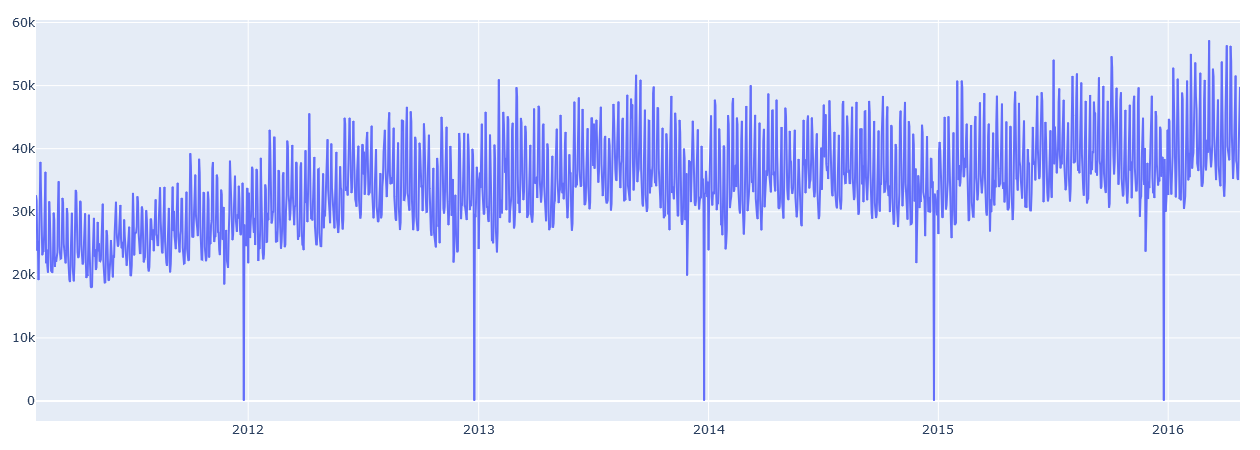

In [22]:
def plot_overall_sales(df):
    df_plot = df.groupby('date', as_index=False).sold_qty.sum()
    
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x=df_plot.date, y=df_plot.sold_qty,
            mode='lines'
        )
    )
    fig.update_layout(
        hovermode="x unified",
        margin=dict(l=20, r=20, t=20, b=20),
    )
    fig.show()

plot_overall_sales(df)

Sales (in term of quantity sold) over all stores and departments over time show a clear upward trend as well as seasonalities on different scales:
* yearly, with lower sales in the summer and around Christmas, where sales even drop to zero (stores closed),
* weekly, with strong sales on saturdays an lower sales on wednesdays/thursdays

Calendar features and lags will likely be useful to capture those seasonality effects.

### Seasonality on overall sales

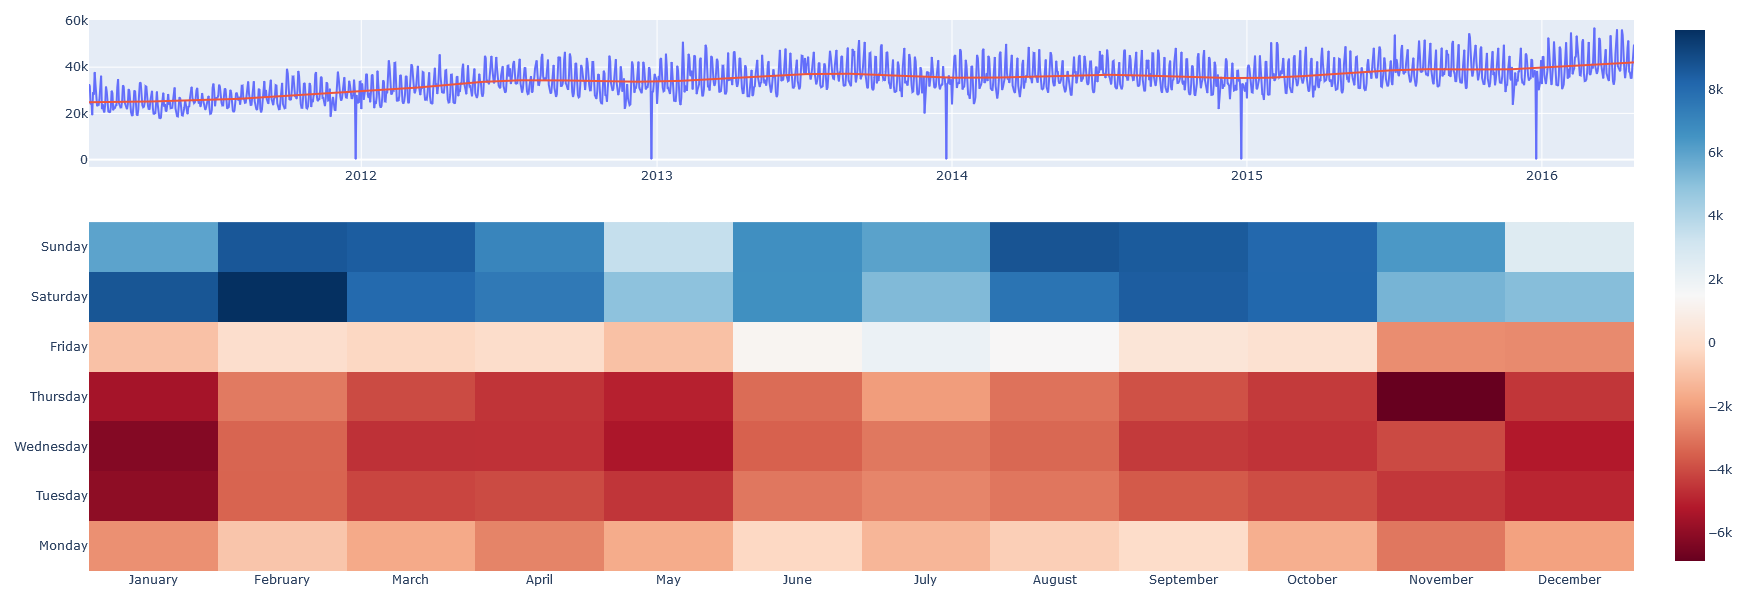

In [102]:
def plot_overall_sales(df):
    df_plot = df.groupby('date', as_index=False).sold_qty.sum()
    
    lowess = sm.nonparametric.lowess
    df_plot['trend'] = lowess(df_plot.sold_qty, df_plot.date, frac=1./ 6, it=0, return_sorted=False)
    
    fig = make_subplots(
        rows=3, cols=1,
        specs=[[{}],
               [{'rowspan': 2}],
               [None]],
        vertical_spacing = 0.1,
    )
    
    fig.add_trace(
        go.Scatter(
            x=df_plot.date, y=df_plot.sold_qty,
            mode='lines',
            name='sales',
            showlegend=False
        ),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(
            x=df_plot.date, y=df_plot.trend,
            mode='lines',
            name='trend',
            showlegend=False
        ),
        row=1, col=1
    )
    
    df_plot['relative_sales'] = df_plot.sold_qty - df_plot.trend
    df_plot['month'] = df_plot.date.dt.month_name()
    df_plot['wday'] = df_plot.date.dt.day_name()
    df_heatmap = df_plot.groupby(['month', 'wday'], as_index=False).relative_sales.mean().pivot(index='wday', columns='month', values='relative_sales')
    df_heatmap = df_heatmap.loc[
        ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
        ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    ]
    
    fig.add_trace(
        go.Heatmap(
            z=df_heatmap,
            x=df_heatmap.columns.to_list(),
            y=df_heatmap.index.to_list(),
            name='Difference to mean',
            colorscale='RdBu',
            showlegend=False
        ),
        row=2, col=1
    )
    
    fig.update_layout(
        hovermode="x unified",
        height=600,
        margin=dict(l=20, r=20, t=20, b=20),
    )
    fig.show()

plot_overall_sales(df)

As the order quantities are not stationary (increasing in time), the seasonality effect is quantified from a difference to a reference instead of in absolute value:
* the trend is determined using a local regression (LOWESS): at each point $y_{t}$, a linear regression is fitted (least squares) on a set of neighbor points of size $N \cdot frac$ around $y_{t}$. Each point in the neighborhood is weighted using the tricube function centered around $y_{t}$ (the farer the neighbor, the smaller the weight).
* at each point, the trend is substracted from the sold quantity to get a relative sold quantity that is detrended
* For each weekday of each month, the average relative sold quantity is computed

The heatmap matrix clearly shows the weekly trend, with saturday and sunday being the days with the largest positive difference to the trend while wednesday and thursday are the largest negatives, thus confirming what can be observed from the timeserie. November and december show a decrease in sales, which was also observed from the timeseries.

It's also interesting to observe that the largest drop observed is on Thursdays of November, which coincide with Thanksgiving, and highest peak is on Saturdays and Sundays of February, when Superbowl usually happens. Special events and holy days seem to have large influence on sales in some cases and as such features related to them will likely make good predictors.

### Weekly Sales per state

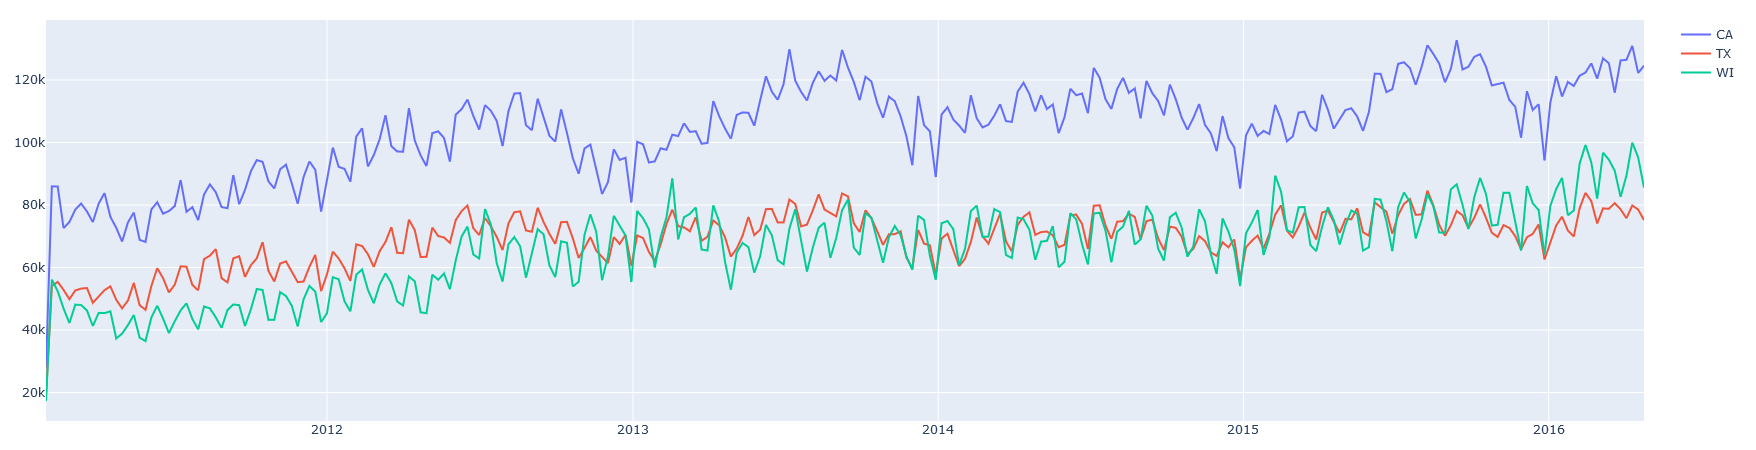

In [121]:
def plot_states_sales(df):
    df_plot = df.groupby([pd.Grouper(key='date', freq='W'), 'state_id']).sold_qty.sum().reset_index()
    
    fig = go.Figure()
    
    for state in df_plot.state_id.unique():
        df_state_sales = df_plot[df_plot.state_id == state]
        fig.add_trace(
            go.Scatter(
                x=df_state_sales.date, y=df_state_sales.sold_qty,
                mode='lines',
                name=state,
            )
        )
    fig.update_layout(
        hovermode="x unified",
        margin=dict(l=20, r=20, t=20, b=20),
    )
    fig.show()

plot_states_sales(df)

Californian sales are substantially higher than the other two states.

Sales per state seem to follow the same upward trend as well as similar weekly seasonality. However, Californian sales are subjected to stronger yearly seasonality effects: except on Christmas, Texas and Wisconsin sales don't show much variations in winter and summer compared to Californian sales. 

Overall, it looks like sales across states follow similar dynamics.

### Seasonality on sales per state

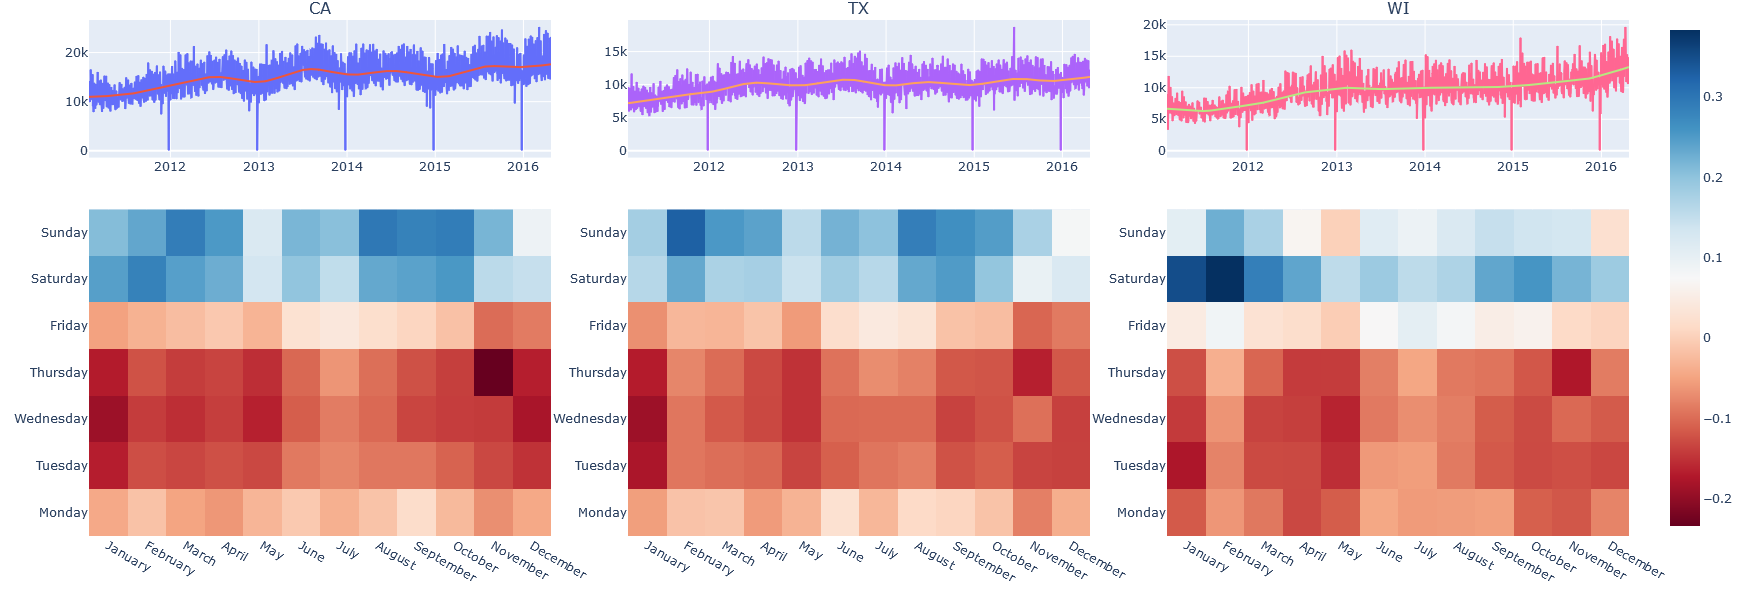

In [120]:
def plot_seasonality_state(df):
    df_plot = df.groupby(['date', 'state_id'], as_index=False).sold_qty.sum()
    lowess = sm.nonparametric.lowess
    
    fig = make_subplots(
        rows=3, cols=3, 
        specs=[[{}, {}, {}],
               [{'rowspan':2}, {'rowspan':2}, {'rowspan':2}],
               [None, None, None]],
        horizontal_spacing = 0.05,
        vertical_spacing = 0.1,
        subplot_titles=df_plot.state_id.unique()
    )
    
    for i, state in enumerate(df_plot.state_id.unique()):
        df_state = df_plot.loc[df_plot.state_id == state].copy()
        
        df_state['trend'] = lowess(df_state.sold_qty, df_state.date, frac=1./ 6, it=0, return_sorted=False)

        fig.add_trace(
            go.Scatter(
                x=df_state.date, y=df_state.sold_qty,
                mode='lines',
                name='sales',
                showlegend=False
            ),
            row=1, col=i+1
        )
        fig.add_trace(
            go.Scatter(
                x=df_state.date, y=df_state.trend,
                mode='lines',
                name='trend',
                showlegend=False
            ),
            row=1, col=i+1
        )
        
        df_state['relative_sales'] = (df_state.sold_qty - df_state.trend) / df_state.trend
        df_state['month'] = df_state.date.dt.month_name()
        df_state['wday'] = df_state.date.dt.day_name()
        df_heatmap = df_state.groupby(['month', 'wday'], as_index=False).relative_sales.mean().pivot(index='wday', columns='month', values='relative_sales')
        df_heatmap = df_heatmap.loc[
            ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
            ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
        ]

        fig.add_trace(
            go.Heatmap(
                z=df_heatmap,
                x=df_heatmap.columns.to_list(),
                y=df_heatmap.index.to_list(),
                name=state,
                coloraxis='coloraxis',
                showlegend=False
            ),
            row=2, col=i+1
        )
    
    fig.update_layout(
        hovermode="x unified",
        coloraxis = {'colorscale':'RdBu'},
        height=600,
        margin=dict(l=20, r=20, t=20, b=20),
    )
    fig.show()

plot_seasonality_state(df)

Here the relative sales difference is normalized to allow comparison across states.
California and Texas stores are rather similar in terms of seasonality, though Texas stores' relative sales differences are maybe a bit less marked. Wisconsin stores seem to have highest differences on saturdays only (with higher intensity as well) and slightly higher ones on sundays, compared to stores in the two other states.

The monthly variations are similar for all the states and to the overall sales.

### Weekly sales per category and stores

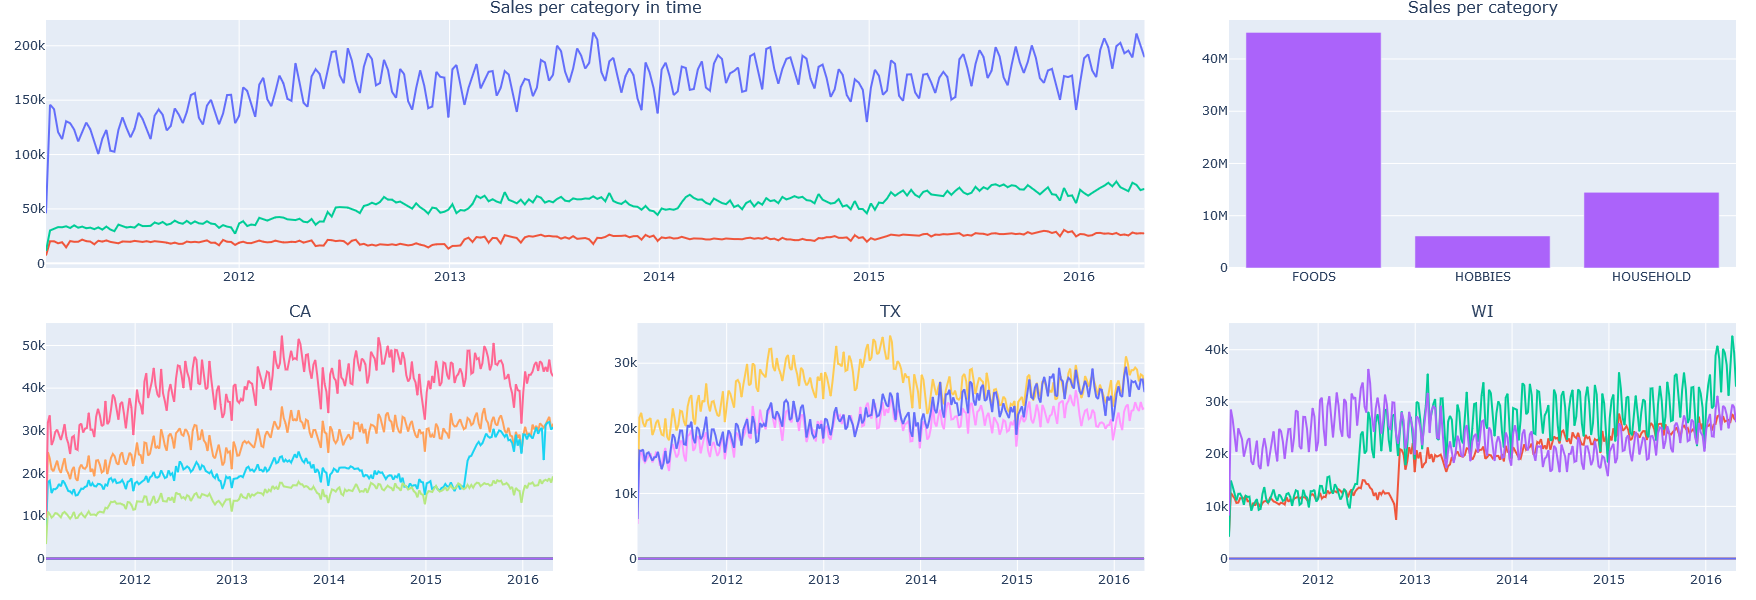

In [109]:
def plot_cat_store_sales(df):
    df_plot = df.groupby([pd.Grouper(key='date', freq='W'), 'state_id', 'store_id', 'cat_id']).sold_qty.sum().reset_index()
    
    fig = make_subplots(
        rows=2, cols=3,
        specs=[[{'colspan':2}, None, {}],
               [{}, {}, {}]],
        subplot_titles=('Sales per category in time', 'Sales per category', *df_plot.state_id.unique()),
        horizontal_spacing = 0.05,
        vertical_spacing = 0.1,
    )
    
    df_plot_cat = df_plot.groupby(['date', 'cat_id'], as_index=False).sold_qty.sum()
    for cat in df_plot_cat.cat_id.unique():
        df_cat_sales = df_plot_cat[df_plot_cat.cat_id == cat]
        fig.add_trace(
            go.Scatter(
                x=df_cat_sales.date, y=df_cat_sales.sold_qty,
                mode='lines',
                name=cat,
                showlegend=False,
            ),
            row=1, col=1
        )
    
    df_plot_cat = df_plot.groupby('cat_id', as_index=False).sold_qty.sum()
    fig.add_trace(
        go.Bar(
            x=df_plot_cat.cat_id, y=df_plot_cat.sold_qty,
            showlegend=False,
        ),
        row=1, col=3
    )
    
    df_plot_store_state = df_plot.groupby(['date', 'state_id', 'store_id'], as_index=False).sold_qty.sum()
    for i, state in enumerate(df_plot_store_state.state_id.unique()):
        for store in df_plot_store_state.store_id.unique():
            df_plot_store = df_plot_store_state[(df_plot_store_state.state_id == state) & (df_plot_store_state.store_id == store)]
            fig.add_trace(
                go.Scatter(
                    x=df_plot_store.date, y=df_plot_store.sold_qty,
                    mode='lines',
                    name=store,
                    showlegend=False,
                ),
                row=2, col=i+1
            )
    
    fig.update_layout(
        hovermode="x unified",
        height=600,
        margin=dict(l=20, r=20, t=20, b=20),
    )
    fig.show()

plot_cat_store_sales(df)

#### Sales per category:
* Food represents the main driver in terms of quantity sold, with sales 3 times higher than for household and 7.5 times higher than hobbies
* Both foods and household items show an upward trend in the quantity sold while it's rather stable when it comes to hobbies

#### Sales per stores and states:
* California: while stores 1 and 3 have pretty similar dynamics (trend and seasonality), stores 2 and 4 look rather different:
    * Stores 3 is leading in terms of quantity sold and show strong seasonality effects. Sales grow from 2011 to 2013 and look stationary afterward.
    * Store 1 is similar to store 3, just with lower amount of quantity sold.
    * Store 4 have a constant upward trend and seasonality effects are not as strong as the two former stores.
    * Store 2 is similar to store 1 from 2011 to 2014 but show a downward trend until June 2015 where sales abruptly increase and become equivalent to store 1. It indicates that some particular event happened around that time.


* Texas: store 2 show great increase from 2011 to september 2013 with sales much higher than the two others. However it sees a large drop afterward and is become equivalent to the other two. Stores 1 and 3 have quite similar dynamics.

* Wisconsin: sales dynamics appear very different from the stores in other states:
    * Store 3 is leading by quite a large difference from 2011 to july 2012 where sales decrease a bit and show a dramatically drop around april 2013.
    * Store 1 have steady sales from 2011 to october 2012 after when it has a sharp increase. The rest is a steady increase.It indicates that something happened around that time. Additionally, seasonality is a lot less marked compared to other stores.
    * Store 2 have similar dynamics to store 1, but an earlier sudden increase and higher amplitude difference in sales.

# Some individual items' sales

# Selling price distributions

# Snap events